## Segment anything on brain segmentation dataset

To run this notebook, following instruction at https://github.com/facebookresearch/segment-anything to install dependency and backbone model.

Model weights should be placed at `./weights/sam_vit_b_01ec64.pth` for example.

This notebook has following sections:

1. Load origin image, groundtruth and prediction by Unet

2. Segment without prompt

3. Segment with central prompt

4. Segment with prompt at tumor

5. Segment with prompt at tumor with a largest backbone model

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

## Load origin image

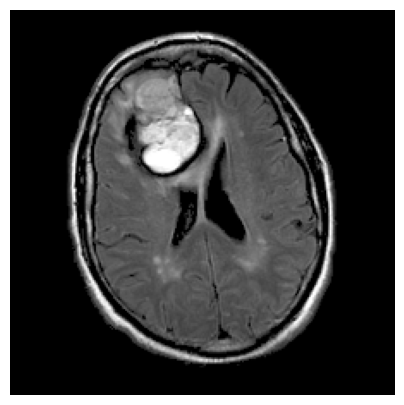

In [14]:
image = cv2.imread('./origin-TCGA_HT_7616_19940813-17.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

## Load segmentation groundtruth and prediction by Unet

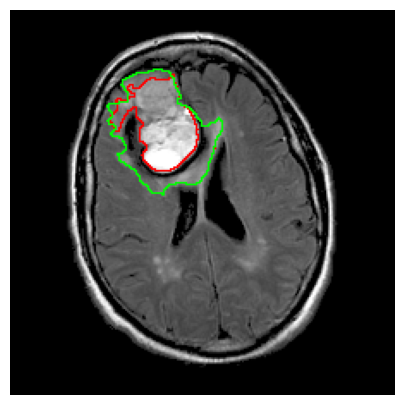

In [33]:
image_pred = cv2.imread('./TCGA_HT_7616_19940813-17.png')
image_pred = cv2.cvtColor(image_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(image_pred)
plt.axis('off')
plt.show()

## Load segment anything package

In [15]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../weights/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

## Generate mask **without** prompts

In [16]:
masks = mask_generator.generate(image)

In [17]:
print(len(masks))
print(masks[0].keys())

11
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [18]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

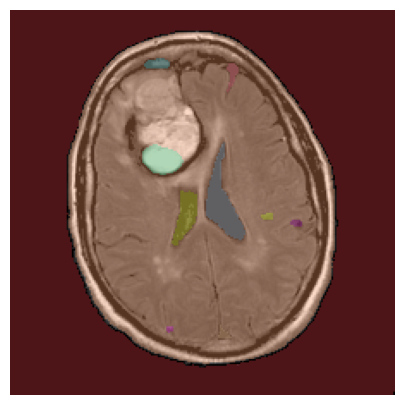

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Generate mask with central prompt

In [20]:
predictor = SamPredictor(sam)
predictor.set_image(image)

## Use central point as input

The original size is (224, 224), so central point is (112, 112)

In [21]:
input_point = np.array([[112, 112]])
input_label = np.array([1])

In [22]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

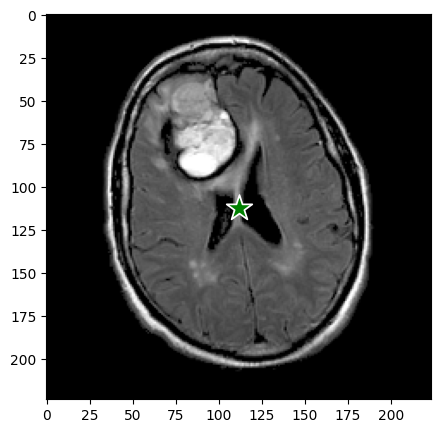

In [24]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

## Predict with SamPredictor.predict

The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [25]:
masks_central, score_centrals, logits_central = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [27]:
masks_central.shape # (number_of_masks) x H x W

(3, 224, 224)

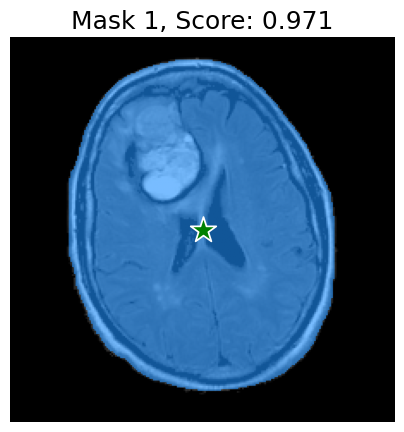

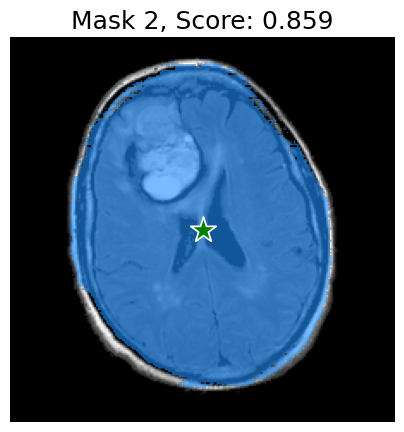

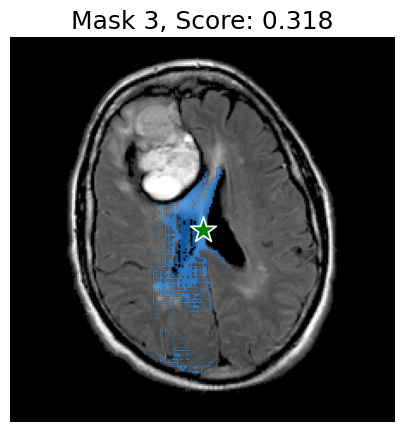

In [28]:
for i, (mask, score) in enumerate(zip(masks_central, score_centrals)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

## Segment with prompt **at tumor**

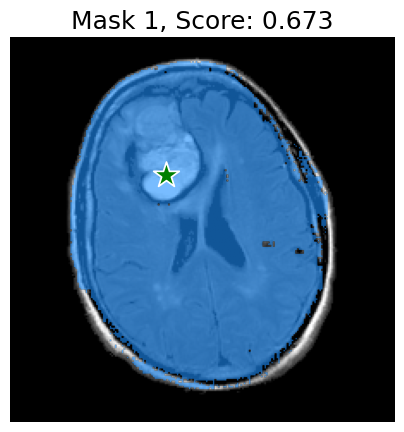

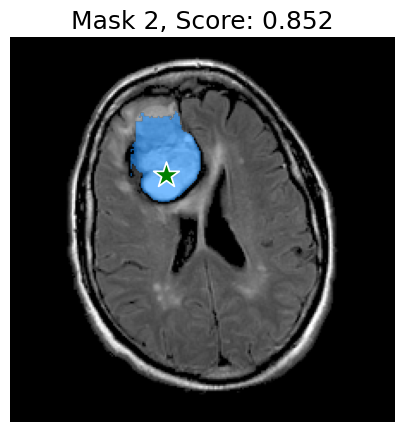

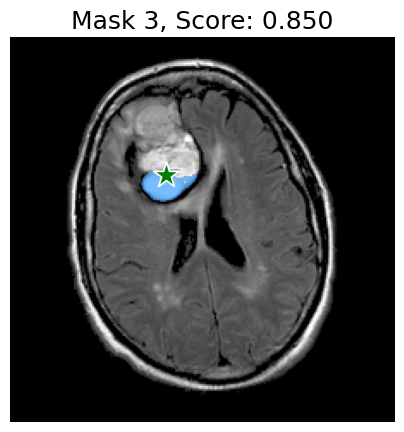

In [30]:
input_point_tumor = np.array([[90, 80]])
input_label_tumor = np.array([1])

masks_tumor, score_tumor, logits_tumor = predictor.predict(
    point_coords=input_point_tumor,
    point_labels=input_label_tumor,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks_tumor, score_tumor)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point_tumor, input_label_tumor, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

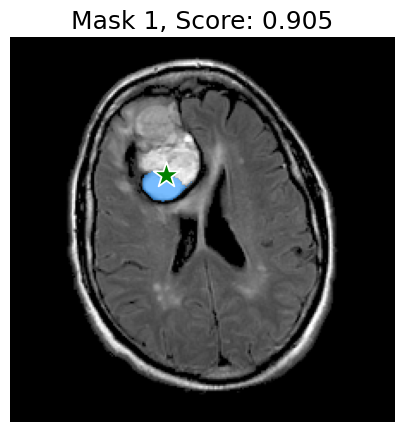

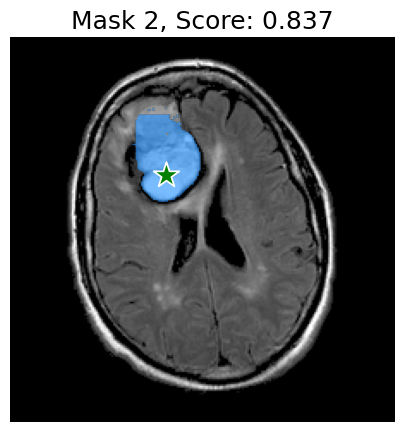

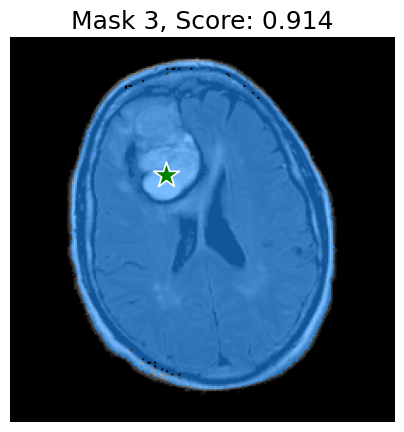

In [34]:
sam_checkpoint = "../weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam_vit_h = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_vit_h.to(device=device)

predictor_vit_h = SamPredictor(sam_vit_h)
predictor_vit_h.set_image(image)

masks_tumor_vit_h, score_tumor_vit_h, logits_tumor_vit_h = predictor_vit_h.predict(
    point_coords=input_point_tumor,
    point_labels=input_label_tumor,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks_tumor_vit_h, score_tumor)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point_tumor, input_label_tumor, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  